In [21]:
%load_ext autoreload
%autoreload 2
%env ANYWIDGET_HMR=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: ANYWIDGET_HMR=1


In [35]:
import pandas as pd
import numpy as np
import sys
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
from plotly import express as px
import scipy as sp
import itertools


from st_utils import correct_tissue_names, correct_platform_panel,name_parser
from st_utils import log2_fold_change
from st_utils import log_transform
from constants import SAMPLES, sample_color, convert_tma_name_dict, CB_COLORS_5
from constants import matching_cores_2024 as matching_cores


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

    
wd = os.getcwd()
print (f'working directory: {wd}')

year = '2023'

if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)
    

working directory: /Users/whuan/dev/ist_benchmarking
['xenium_breast_htma', 'xenium_breast_normal', 'xenium_panhuman_htma', 'xenium_panhuman_normal', 'xenium_lung_htma', 'xenium_lung_normal', 'merscope_breast_htma', 'merscope_breast_normal', 'merscope_lung_htma', 'merscope_lung_normal', 'cosmx_multitissue_htma', 'cosmx_multitissue_normal']


In [36]:
supplement=True

# Functions to load data and calculate specificity , sensitivity

In [37]:

def load(sample): # Load gene level data and tag with core metadata
    # Core information: including tissue_type, tumor ...
    csv_sample_info = f"{wd}/data/Sample_Info_{name_parser(sample)['tma'].upper()}_TMA - Sheet1.csv"
    df_core = pd.read_csv(csv_sample_info)[['core','tissue_type']]
    df_core = correct_tissue_names(sample,df_core)
    df_core['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)

    # Rachel curated gene list
    gene_list = pd.read_csv(f"{wd}/data/gene_lists/{name_parser(sample)['platform']}_{name_parser(sample)['panel']}.csv").columns.to_list()

    # Core x gene
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_t = correct_tissue_names(sample,df_t)
    df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)

    return df_t, df_core, gene_list

def specificity(sample, df_t, df_core):
    """Fraction of calls on target"""

    df_g = df_t.groupby(['core','tissue_type','code_type']).sum().reset_index()
    valid_tissues = sorted(df_t.tissue_type.unique())

    if 'Marker' in valid_tissues:
        valid_tissues.remove('Marker')
    if 'MARKER' in valid_tissues:
        valid_tissues.remove('MARKER')

    df_mat = df_g.pivot_table(index='core',columns='code_type',values='count', aggfunc='sum')
    df_mat = df_mat.fillna(0)
    df_mat['specificity'] = df_mat['gene']/df_mat.sum(axis=1)
    df_mat = pd.merge(df_core, df_mat, on='core', how='inner')

    # Save data
    df_mat.to_csv(f'{wd}/data/specificity/{sample}_specificity.csv', index=False)

def sensitivity(sample, df_t, df_core, matching_cores):
    """Number of gene reliably detected above noise (2 STD above average negative control expression)"""

    df_pos_genes = pd.DataFrame()
    neg_metric = 'blank' if 'merscope' in sample else 'neg_control_probe'
    genes = df_t.loc[df_t['code_type']=='gene']['gene'].unique()
    n_genes = df_t.loc[df_t['code_type']=='gene']['gene'].nunique()
    negative_controls = df_t.loc[df_t['code_type']==neg_metric]['gene'].unique()
    df_t = df_t.loc[df_t['core'].isin(matching_cores)]

    df2_mat = df_t.pivot(index='gene',columns='core',values='count').fillna(0)
    mean_neg_probes = df2_mat.loc[negative_controls].mean()
    sd_neg_probes = df2_mat.loc[negative_controls].std()

    i = 2 # Number of STD

    df_pos_genes[f'mean+{i}std'] = np.sum(df2_mat.loc[genes] > (mean_neg_probes + i * sd_neg_probes))
    # normalize by number of genes
    df_pos_genes[f'mean+{i}std_%'] = df_pos_genes[f'mean+{i}std'] * 100 / n_genes

    df_pos_genes = pd.merge(df_pos_genes, df_core, on='core', how='inner')
    df_pos_genes_mean = df_pos_genes.groupby('tissue_type').mean()
    df_pos_genes_mean.to_csv(f'{wd}/data/gene_above_noise/{sample}_gene_above_noise.csv')

    return n_genes


# Calculate specificity, sensitivity for multiple data sets

In [38]:
if not os.path.exists(f'{wd}/data/specificity'):
    os.makedirs(f'{wd}/data/specificity')

if not os.path.exists(f'{wd}/data/gene_above_noise'):
    os.makedirs(f'{wd}/data/gene_above_noise')


sample_genes = {}

df_cores_htma = pd.read_csv(f'{wd}/data/core_availability_htma.csv')
df_cores_normal = pd.read_csv(f'{wd}/data/core_availability_normal.csv')
df_cores_tumor2 = pd.read_csv(f'{wd}/data/core_availability_tumor2.csv')

df_cores_both = pd.DataFrame()
df_cores_both = pd.concat([df_cores_both, df_cores_htma]) 
df_cores_both = pd.concat([df_cores_both, df_cores_normal])
df_cores_both = pd.concat([df_cores_both, df_cores_tumor2])

df_matching_cores = {}
matching_cores = []

for tma in ['htma', 'normal','tumor2']:
    df = df_cores_both.copy()
    for s in samples:
        if tma in s:
            df = df.loc[df[s] == 1.0]
    df_matching_cores[tma] = df
    print (df['core'].nunique(), f'cores in all {tma} tma samples')

matching_cores = list(df_matching_cores['normal']['core'].unique())+list(df_matching_cores['htma']['core'].unique())+list(df_matching_cores['tumor2']['core'].unique())
matching_cores = sorted(matching_cores)

df_t_all = {}


tma = 'both'  # both, tumor, normal

if tma == 'both':
    run_samples = samples
elif tma == 'tumor':
    run_samples = [x for x in samples if tma in x]
elif tma == 'normal':
    run_samples = [x for x in samples if tma in x]
elif tma == 'tumor2':
    run_samples = [x for x in samples if tma in x]
else:
    print ('error')



for sample in run_samples:
    print (f'sample: {sample}')
    df_t, df_core, gene_list = load(sample)
    df_t_all[sample] = df_t
    specificity(sample, df_t, df_core)
    n_genes = sensitivity(sample, df_t, df_core, matching_cores)
    sample_genes[f"{name_parser(sample)['platform'].upper()}_{name_parser(sample)['panel'].capitalize()}"] = n_genes
display(sample_genes)


69 cores in all htma tma samples
34 cores in all normal tma samples
272 cores in all tumor2 tma samples
sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


{'XENIUM_Breast': 280,
 'XENIUM_Panhuman': 377,
 'XENIUM_Lung': 289,
 'MERSCOPE_Breast': 255,
 'MERSCOPE_Lung': 220,
 'COSMX_Multitissue': 1000}

In [39]:
metric = 'specificity'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/specificity/{sample}_specificity.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    df_m = df_m[['core','tissue_type','sample','specificity']]
df_m = df_m.loc[df_m['core'].isin(matching_cores)]


sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


# Review specificity

In [40]:
metric = 'specificity'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/specificity/{sample}_specificity.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    df_m = df_m[['core','tissue_type','sample','specificity']]
df_m = df_m.loc[df_m['core'].isin(matching_cores)]

df_m['Platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'].capitalize())
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())


###
### By Platform * panel
###

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel','tma']).agg({'specificity': 'mean'}).reset_index()
df_plot['Platform_Panel'] = df_plot.apply(lambda row: f"{row['Platform']}_{row['panel']}", axis=1)
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')
df_plot['specificity'] = df_plot['specificity'] * 100
df_plot['specificity'] = df_plot['specificity'].apply(lambda x: round(x,2))
# display(df_plot[['Platform_Panel','specificity']].groupby(['Platform_Panel']).mean().round(1))
df_p_p = df_plot.copy()


###
### By Platform
###

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','tma']).agg({'specificity': 'mean'}).reset_index()
df_plot['specificity'] = df_plot['specificity'] * 100
df_plot['specificity'] = df_plot['specificity'].apply(lambda x: round(x,2))

df_plot_spe = df_plot.copy()
df_plot_spe = df_plot_spe.rename(columns={metric:'value'})
df_plot_spe['metric'] = '% calls on genes'
df_plot_spe = df_plot_spe.groupby(['tissue_type','Platform','metric','tma']).agg({'value': 'mean'}).reset_index()

if supplement:
    df_plot_spe = df_p_p.copy()
    df_plot_spe = df_plot_spe.rename(columns={metric:'value'})
    df_plot_spe['metric'] = '% calls on genes'
    df_plot_spe = df_plot_spe.groupby(['tissue_type','Platform_Panel','metric','tma']).agg({'value': 'mean'}).reset_index()
    
display(df_plot_spe.head(5))

sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


,tissue_type,Platform_Panel,metric,tma,value
0,BlC,"CosMx,1k",% calls on genes,HTMA,97.45
1,BlC,"MERSCOPE,Breast",% calls on genes,HTMA,98.90
2,BlC,"Xenium,Breast",% calls on genes,HTMA,99.03
3,BlC,"Xenium,Lung",% calls on genes,HTMA,99.60
4,BlC,"Xenium,Multi-tissue",% calls on genes,HTMA,99.67


# Review sensitivity by total number
In the absence of paired RNA-seq data for each individual sample, we quantified sensitivity by measuring the number
of genes detected above noise. For each core, we calculated the number of genes detected one, two, and three
standard deviations above the average of the 20 negative control probes. These numbers were then averaged for
cores of the same tissue type. As expected, the number of genes detected decreased with increasing stringency. All
genes were detected at least once in each TMA.

In [41]:
i = 2
metric = f'mean+{i}std'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/gene_above_noise/{sample}_gene_above_noise.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    
df_m['Platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'].capitalize())
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel','tma']).agg({metric: 'mean'}).reset_index()
df_plot['Platform_Panel'] = df_plot.apply(lambda row: f"{row['Platform']}_{row['panel']}", axis=1)
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')
df_p_p = df_plot.copy()

### By Platform
df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel','tma']).agg({metric: 'mean'}).reset_index()

df_plot_sen = df_plot.copy()
df_plot_sen = df_plot_sen.rename(columns={metric:'value'})
df_plot_sen['metric'] = 'genes above noise'
df_plot_sen = df_plot_sen.drop('panel', axis=1)
df_plot_sen = df_plot_sen.groupby(['tissue_type','Platform','metric','tma']).agg({'value': 'mean'}).reset_index()

if supplement:
    df_plot_sen = df_p_p.copy()
    df_plot_sen = df_plot_sen.rename(columns={metric:'value'})
    df_plot_sen['metric'] = 'genes above noise'
    df_plot_sen = df_plot_sen.drop('panel', axis=1)
    df_plot_sen = df_plot_sen.groupby(['tissue_type','Platform_Panel','metric','tma']).agg({'value': 'mean'}).reset_index()

df_plot_sen.head()

sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


,tissue_type,Platform_Panel,metric,tma,value
0,BlC,"CosMx,1k",genes above noise,HTMA,455.944444
1,BlC,"MERSCOPE,Breast",genes above noise,HTMA,115.750000
2,BlC,"Xenium,Breast",genes above noise,HTMA,226.619048
3,BlC,"Xenium,Lung",genes above noise,HTMA,272.533333
4,BlC,"Xenium,Multi-tissue",genes above noise,HTMA,354.529412


# Review sensitivity by %

In [42]:
i = 2
metric = f'mean+{i}std_%'
df_m = pd.DataFrame()
for sample in run_samples:
    print (f'sample: {sample}')
    df_metric = pd.read_csv(f'{wd}/data/gene_above_noise/{sample}_gene_above_noise.csv')
    df_metric['sample'] = sample
    df_m = pd.concat([df_m,df_metric])
    
df_m['Platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'].capitalize())
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel','tma']).agg({metric: 'mean'}).reset_index()
df_plot['Platform_Panel'] = df_plot.apply(lambda row: f"{row['Platform']}_{row['panel']}", axis=1)
df_plot = correct_platform_panel(df_plot, 'Platform_Panel')
df_p_p = df_plot.copy()

### By Platform
df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['tissue_type','Platform','panel','tma']).agg({metric: 'mean'}).reset_index()

df_plot_sen_pa = df_plot.copy()
df_plot_sen_pa = df_plot_sen_pa.rename(columns={metric:'value'})
df_plot_sen_pa['metric'] = '% genes above noise'
df_plot_sen_pa = df_plot_sen_pa.drop('panel', axis=1)
df_plot_sen_pa = df_plot_sen_pa.groupby(['tissue_type','Platform','metric','tma']).agg({'value': 'mean'}).reset_index()

if supplement:
    df_plot_sen_pa = df_p_p.copy()
    df_plot_sen_pa = df_plot_sen_pa.rename(columns={metric:'value'})
    df_plot_sen_pa['metric'] = '% genes above noise'
    df_plot_sen_pa = df_plot_sen_pa.drop('panel', axis=1)
    df_plot_sen_pa = df_plot_sen_pa.groupby(['tissue_type','Platform_Panel','metric','tma']).agg({'value': 'mean'}).reset_index()

df_plot_sen_pa.head()

sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


,tissue_type,Platform_Panel,metric,tma,value
0,BlC,"CosMx,1k",% genes above noise,HTMA,45.594444
1,BlC,"MERSCOPE,Breast",% genes above noise,HTMA,45.392157
2,BlC,"Xenium,Breast",% genes above noise,HTMA,80.935374
3,BlC,"Xenium,Lung",% genes above noise,HTMA,94.302191
4,BlC,"Xenium,Multi-tissue",% genes above noise,HTMA,94.039632


In [43]:
if not os.path.exists('tables'):
    os.makedirs('tables')

if supplement:

    total_gene_dict = {
        'Xenium,Breast':280,
        'Xenium,Multi-tissue':377,
        'Xenium,Lung':289,
        'MERSCOPE,Breast':255,
        'MERSCOPE,Lung':220,
        'CosMx,1k':1000,
    }

    df_p_p['total_gene'] = df_p_p['Platform_Panel'].apply(lambda x: total_gene_dict[x])
    df_p_p['sensed_gene'] = df_p_p.apply(lambda row: int(row['mean+2std_%'] * row['total_gene'] * 0.01), axis=1)

    metric = 'Sensed Genes'
    original_metric = 'mean+2std_%'  # sensed_gene
    df = df_p_p[['tissue_type','Platform_Panel',original_metric]] 
    df = df.rename(columns = {'tissue_type':'Tissue Type', original_metric:'Sensed Genes'})

    pivoted_df = df.pivot_table(index='Tissue Type', columns='Platform_Panel', values=metric)
    pivoted_df.reset_index(inplace=False)

    pivoted_df.to_csv(f'{wd}/tables/sensed_genes.csv')


# Function to apply styling to the maximum value in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: limegreen; text-align: center' if v else 'background-color: white; text-align: center' for v in is_max]

# Apply the style with highlighted maximum values and centered text
styled_df = pivoted_df.style.apply(highlight_max, axis=1)

# Display the styled DataFrame
styled_df

Platform_Panel,"CosMx,1k","MERSCOPE,Breast","MERSCOPE,Lung","Xenium,Breast","Xenium,Lung","Xenium,Multi-tissue"
Tissue Type,,,,,,
BlC,45.594444,45.392157,nan,80.935374,94.302191,94.039632
Bladder,27.400000,39.607843,56.363636,56.964286,83.391003,48.408488
BrC,50.022222,58.009050,43.566434,93.670635,93.750000,92.160330
Breast,43.133333,38.692810,41.515152,82.380952,93.425606,92.219275
CRC,40.804000,57.980392,55.064935,76.944444,90.401685,88.359518
Colon,24.133333,39.869281,33.939394,75.238095,92.387543,82.493369
HNSCC,36.360000,52.885154,45.312500,90.214286,84.457901,89.092838
Heart,21.866667,11.633987,21.060606,57.976190,64.244521,64.633068
Kidney,22.833333,60.980392,59.848485,96.785714,96.309112,95.137047


In [44]:
## FDR negative
df_fdr1_orignal = pd.read_csv(f'{wd}/data/fdr/negative_{year}.csv')
df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].isin(run_samples)]
df_fdr1_orignal = correct_tissue_names('tumor2',df_fdr1_orignal)
df_fdr1_orignal['tma'] = df_fdr1_orignal['sample'].apply(lambda x: name_parser(x)['tma'].upper())
if tma == 'tumor':
    df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].str.contains('htma')]
elif tma == 'normal':
    df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].str.contains('normal')]
elif tma == 'tumo2':
    df_fdr1_orignal = df_fdr1_orignal.loc[df_fdr1_orignal['sample'].str.contains('tumor2')]
else:
    df_fdr1_orignal = df_fdr1_orignal.copy()

df_fdr1 = df_fdr1_orignal.drop(['sample','panel'], axis=1)
df_fdr1 = df_fdr1.rename(columns={'fdr':'value', 'modality':'Platform'})
df_fdr1['metric'] = 'Log₁₀FDR(negative)'
df_fdr1 = df_fdr1.groupby(['tissue_type','Platform','metric','tma']).agg({'value': 'mean'}).reset_index()
df_fdr1['value'] = df_fdr1['value'].replace(0, 0.0001)
df_fdr1['value'] = np.log10(df_fdr1['value'])

if supplement:
    df_fdr1 = df_fdr1_orignal.rename(columns={'fdr':'value'})
    df_fdr1['metric'] = 'Log₁₀FDR(negative)'
    df_fdr1 = df_fdr1.groupby(['tissue_type','Platform_Panel','metric','tma']).agg({'value': 'mean'}).reset_index()
    df_fdr1['value'] = df_fdr1['value'].replace(0, 0.0001)
    df_fdr1['value'] = np.log10(df_fdr1['value'])


# FDR blank
df_fdr2_original = pd.read_csv(f'{wd}/data/fdr/blank_{year}.csv')
df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].isin(run_samples)]
df_fdr2_original = correct_tissue_names('tumor2',df_fdr2_original)
df_fdr2_original['tma'] = df_fdr2_original['sample'].apply(lambda x: name_parser(x)['tma'].upper())
if tma == 'tumor':
    df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].str.contains('htma')]
elif tma == 'normal':
    df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].str.contains('normal')]
elif tma == 'tumo2':
    df_fdr2_original = df_fdr2_original.loc[df_fdr2_original['sample'].str.contains('tumor2')]
else:
    df_fdr2_original = df_fdr2_original.copy()

df_fdr2 = df_fdr2_original.drop(['sample','panel'], axis=1)
df_fdr2 = df_fdr2.rename(columns={'fdr':'value', 'modality':'Platform'})
df_fdr2['metric'] = 'Log₁₀FDR(blank)'
df_fdr2 = df_fdr2.groupby(['tissue_type','Platform','metric','tma']).agg({'value': 'mean'}).reset_index()
df_fdr2['value'] = df_fdr2['value'].replace(0, 0.0001)
df_fdr2['value'] = np.log10(df_fdr2['value'])

if supplement:
    df_fdr2 = df_fdr2_original.rename(columns={'fdr':'value'})
    df_fdr2['metric'] = 'Log₁₀FDR(blank)'
    df_fdr2 = df_fdr2.groupby(['tissue_type','Platform_Panel','metric','tma']).agg({'value': 'mean'}).reset_index()
    df_fdr2['value'] = df_fdr2['value'].replace(0, 0.0001)
    df_fdr2['value'] = np.log10(df_fdr2['value'])

# Combine all
df_plot = pd.DataFrame()
df_plot = pd.concat([df_plot_sen, df_plot_sen_pa])
df_plot = pd.concat([df_plot, df_plot_spe])
df_plot = pd.concat([df_plot, df_fdr1])
df_plot = pd.concat([df_plot, df_fdr2])
df_plot['Platform_Panel'] = df_plot['Platform_Panel'].apply(lambda x: x.replace('breast','Breast'))
df_plot['Platform_Panel'] = df_plot['Platform_Panel'].apply(lambda x: x.replace('lung','Lung'))
df_plot['Platform_Panel'] = df_plot['Platform_Panel'].apply(lambda x: x.replace('multi','Multi'))
df_plot['tissue_type'] = df_plot['tissue_type'].apply(lambda x: x.replace('Pancreas cancer','Pancreatic cancer'))
df_plot['tissue_type'] = df_plot['tissue_type'].apply(lambda x: x.replace('Testes cancer','Testicular cancer'))
# df_plot = df_plot.loc[~df_plot['tissue_type'].isin(['Pancreas','Renal pelvis'])]
df_plot = df_plot[~df_plot['tissue_type'].str.contains('Marker', na=False)]

df_plot = df_plot.reset_index()

df_plot.head()

,index,tissue_type,Platform_Panel,metric,tma,value
0,0,BlC,"CosMx,1k",genes above noise,HTMA,455.944444
1,1,BlC,"MERSCOPE,Breast",genes above noise,HTMA,115.750000
2,2,BlC,"Xenium,Breast",genes above noise,HTMA,226.619048
3,3,BlC,"Xenium,Lung",genes above noise,HTMA,272.533333
4,4,BlC,"Xenium,Multi-tissue",genes above noise,HTMA,354.529412


In [45]:

if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')

if year == '2024':    

    df_plotly = df_plot.copy()
    df_plotly['tma'] = df_plotly['tma'].apply(lambda x: f"{convert_tma_name_dict[x]}({year[-2:]})")
    df_plotly['tma_tissue'] = df_plotly['tma'] + '_' + df_plotly['tissue_type']
    df_plotly = df_plotly.loc[~df_plotly['tma_tissue'].isin(
        [
            'tTMA1(24)_BlC',
            'tTMA2(24)_Liposarcoma',
        ])]

    df_plotly = df_plotly.sort_values(by='tma_tissue').reset_index()

    fontsize=15
    width = 1000
    if supplement:
        width=1200
    height = 1100
    groupby = 'Platform'
    if supplement:
        groupby = 'Platform_Panel'
        custom_palette = {}
        for Platform_Panel in df_plotly['Platform_Panel'].unique():
            custom_palette[Platform_Panel] = sample_color[Platform_Panel]

    # Define your initial figure
    fig = px.bar(df_plotly, x="tma_tissue", y="value",
                color=groupby, barmode="group", 
                facet_row="metric", color_discrete_map=custom_palette,
                width=width, height=height,
                category_orders={"metric": ['% calls on genes',
                                            'Log₁₀FDR(blank)',
                                            'Log₁₀FDR(negative)',
                                            'genes above noise',
                                            '% genes above noise']})


    print ('FDR was log10 transformed to show the difference, hard to see xenium when cosmx FDR is around 100.')

    # Update x-axis settings with black text
    fig.update_xaxes(tickvals=df_plotly['tma_tissue'].unique(),
                    tickangle=90, title_text='', 
                    title_font=dict(color='black'), tickfont=dict(color='black', size=fontsize))


    # Update y-axis settings with black text
    fig.update_yaxes(matches=None, title_text='', title_font=dict(color='black'), tickfont=dict(color='black', size=fontsize-2))
    fig.update_yaxes(row=1, range=[0, 102], title_font=dict(color='black'), tickfont=dict(color='black'))
    fig.update_yaxes(row=2, range=[0, 700], title_font=dict(color='black'), tickfont=dict(color='black'))
    fig.update_yaxes(row=3, range=[-1, 2], title_font=dict(color='black'), tickfont=dict(color='black'))
    fig.update_yaxes(row=4, range=[-1, 2], title_font=dict(color='black'), tickfont=dict(color='black'))
    fig.update_yaxes(row=5, range=[90,102], title_font=dict(color='black'), tickfont=dict(color='black'))

    fig.update_xaxes(row=1, showline=True, linewidth=2, linecolor='black')
    fig.update_xaxes(row=2, showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes(row=3, zeroline=True, zerolinewidth=2, zerolinecolor='black')
    fig.update_yaxes(row=4, zeroline=True, zerolinewidth=2, zerolinecolor='black')
    fig.update_xaxes(row=5, showline=True, linewidth=2, linecolor='black')

    fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

    # Update legend settings
    fig.update_layout(
        legend=dict(
            title='',
            orientation="h",  # horizontal alignment
            yanchor="bottom", 
            y=0.98,  # position legend just above the plot
            xanchor="center",
            x=0.5  # center the legend
        ),
        font=dict(color='black'),  # Set global font color to black
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        
    )

    # Modify row title annotations and set text color to black
    for annotation in fig.layout.annotations:
        annotation.font.size = fontsize
        annotation.font.color = 'black'  # Set the annotation text color to black
        annotation.x = -0.06
        annotation.textangle = 270
        for metric in df_plot.metric.unique():
            if annotation.text == f'metric={metric}':
                annotation.text = metric

    # Display the figure and save to file
    fig.show()
    if supplement:
        pio.write_image(fig, f'{wd}/figures/Fig_2_Technical_Performance/Supp_Fig_2_tech_{year}_{tma}_tma.png',scale=4, width=width, height=height)
        pio.write_image(fig, f'{wd}/figures/Fig_2_Technical_Performance/Supp_Fig_2_tech_{year}_{tma}_tma.eps',scale=4, width=width, height=height)
    else:
        pio.write_image(fig, f'{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_tech_{year}_{tma}_tma.png',scale=4, width=width, height=height)
        pio.write_image(fig, f'{wd}/figures/Fig_2_Technical_Performance/Main_Fig_2_tech_{year}_{tma}_tma.eps',scale=4, width=width, height=height)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


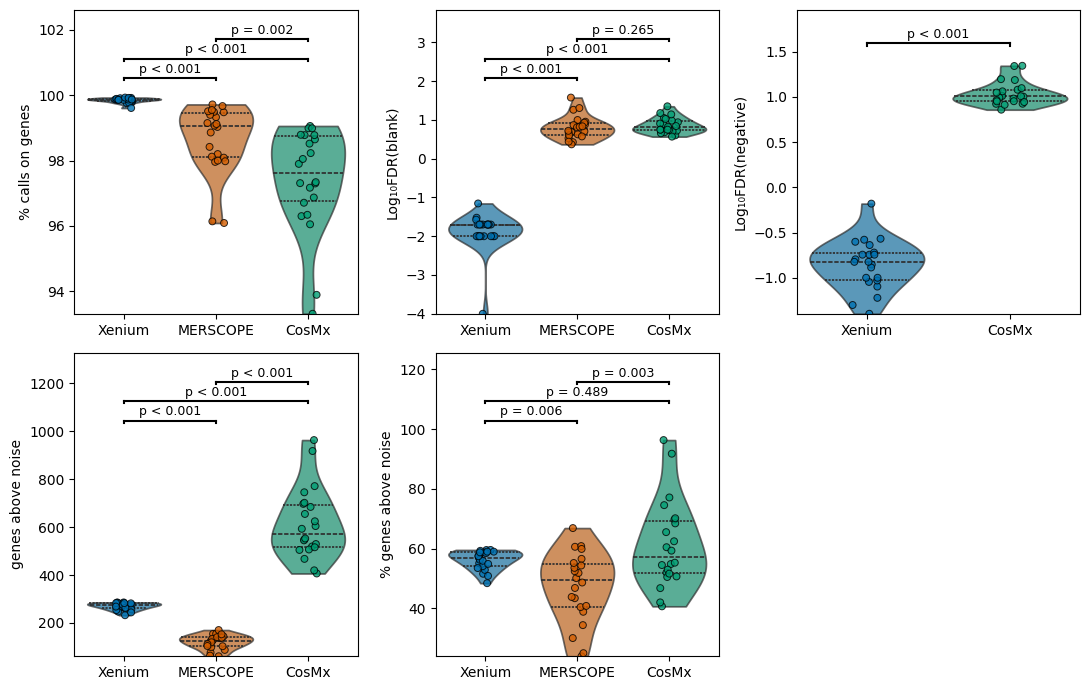

In [46]:
df_plotly.head()
df_all = df_plotly.copy()
df_all['platform'] = df_all['Platform_Panel'].apply(lambda x: x.split(',')[0])
df_all.head()

metrics = [
    '% calls on genes',
    'Log₁₀FDR(blank)',
    'Log₁₀FDR(negative)',
    'genes above noise',
    '% genes above noise',
]

palette = {
    'Xenium': CB_COLORS_5['blue_dark'],
    'MERSCOPE': CB_COLORS_5['red'],
    'CosMx':   CB_COLORS_5['green']
}

fig, axes = plt.subplots(2, 3, figsize=(11, 7), sharey=False)
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    subset = df_all[df_all['metric'] == metric]
    platform_order = ['Xenium', 'MERSCOPE', 'CosMx']

    if metric == 'Log₁₀FDR(negative)':
        subset = subset.loc[subset['platform'] != 'MERSCOPE']
        platform_order = ['Xenium', 'CosMx']

    sns.violinplot(
        x='platform',
        y='value',
        data=subset,
        palette=palette,
        order=platform_order,
        cut=0,
        scale='width',
        inner='quart',
        alpha=0.7,
        ax=ax
    )

    sns.stripplot(
        x='platform',
        y='value',
        data=subset,
        hue='platform',
        palette=palette,
        dodge=False,
        order=platform_order,
        edgecolor='black',
        linewidth=0.7,
        alpha=0.8,
        ax=ax
    )

    ax.set_title('')
    ax.set_xlabel("")
    ax.set_ylabel(metric)

    # Calculate bracket spacing
    x_positions = {p: idx for idx, p in enumerate(platform_order)}
    y_max = subset['value'].max()
    y_min = subset['value'].min()
    # Increase bracket_step to add more vertical space between brackets
    bracket_step = 0.09 * (y_max - y_min) if (y_max - y_min) != 0 else 0.08
    bracket_count = 0

    for (p1, p2) in itertools.combinations(platform_order, 2):
        data1 = subset.loc[subset['platform'] == p1, 'value']
        data2 = subset.loc[subset['platform'] == p2, 'value']
        stat, pval = sp.stats.mannwhitneyu(data1, data2, alternative='two-sided')

        bracket_count += 1
        bracket_y = y_max + bracket_count * bracket_step

        x1, x2 = x_positions[p1], x_positions[p2]
        if x1 > x2:
            x1, x2 = x2, x1

        # Horizontal bracket
        ax.plot([x1, x2], [bracket_y, bracket_y], lw=1.5, color='black')
        # Vertical lines
        ax.plot([x1, x1], [bracket_y, bracket_y - 0.01*(y_max - y_min)], lw=1.5, color='black')
        ax.plot([x2, x2], [bracket_y, bracket_y - 0.01*(y_max - y_min)], lw=1.5, color='black')

        if pval < 0.001:
            p_text = "p < 0.001"
        else:
            p_text = f"p = {pval:.3f}"

        ax.text(
            0.5 * (x1 + x2),
            bracket_y + 0.01*(y_max - y_min),
            p_text,
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

    # Expand y-limits to ensure all brackets and text are visible
    ax.set_ylim(y_min, y_max + (bracket_count + 1.5) * bracket_step)

if len(metrics) < len(axes):
    extra_ax = axes[-1]
    extra_ax.set_visible(False)

plt.tight_layout()
plt.savefig(f'{wd}/figures/response_letter/Fig_2_d_to_h_violin_{year}.png', 
            dpi=250, transparent=True)
plt.savefig(f'{wd}/figures/response_letter/Fig_2_d_to_h_violin_{year}.eps', 
            dpi=250, transparent=True)
plt.show()


# Panel to panel reproducibity

In [18]:
samples = [sample for sample in SAMPLES[:12]]

for sample in samples:
    print (f'sample: {sample}')
    df_t, df_core, gene_list = load(sample)
    df_t_all[sample] = df_t

df_all = {}

Platform_Panels =  ['Xenium,breast',
                    'Xenium,multi-tissue',
                    'Xenium,lung',
                    'MERSCOPE,breast',
                    'MERSCOPE,lung',
                    'CosMx,1k']

for i in range(0,6):
    df_all[Platform_Panels[i]] = pd.DataFrame()
    df_htma = df_t_all[samples[2*i]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_htma])
    df_normal = df_t_all[samples[2*i+1]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_normal])

sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


Xenium,breast vs. Xenium,multi-tissue


1.09

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


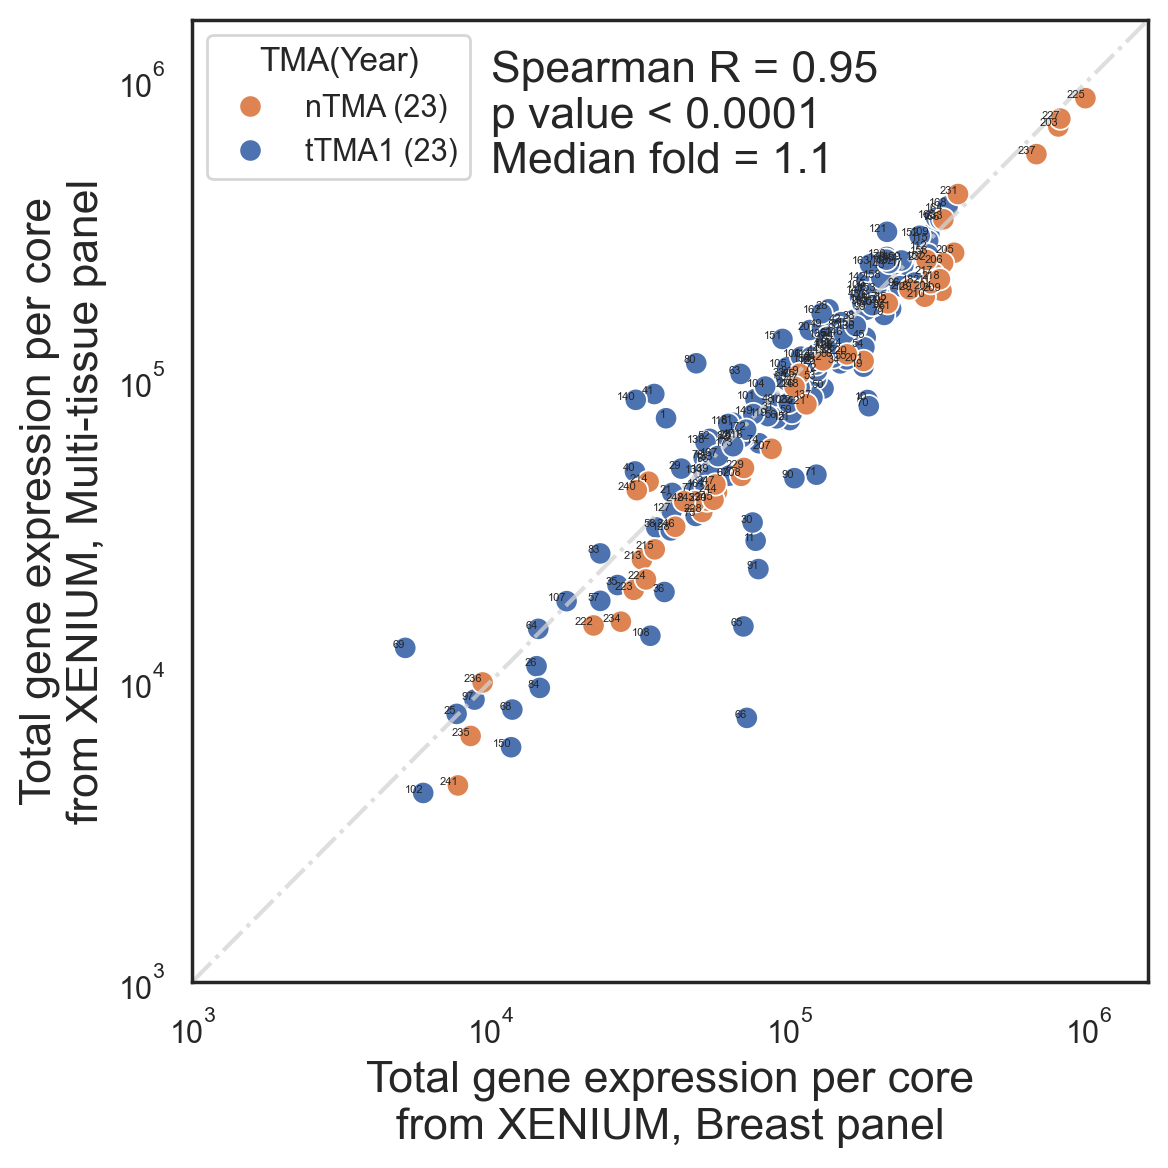

Xenium,breast vs. Xenium,lung


1.28

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


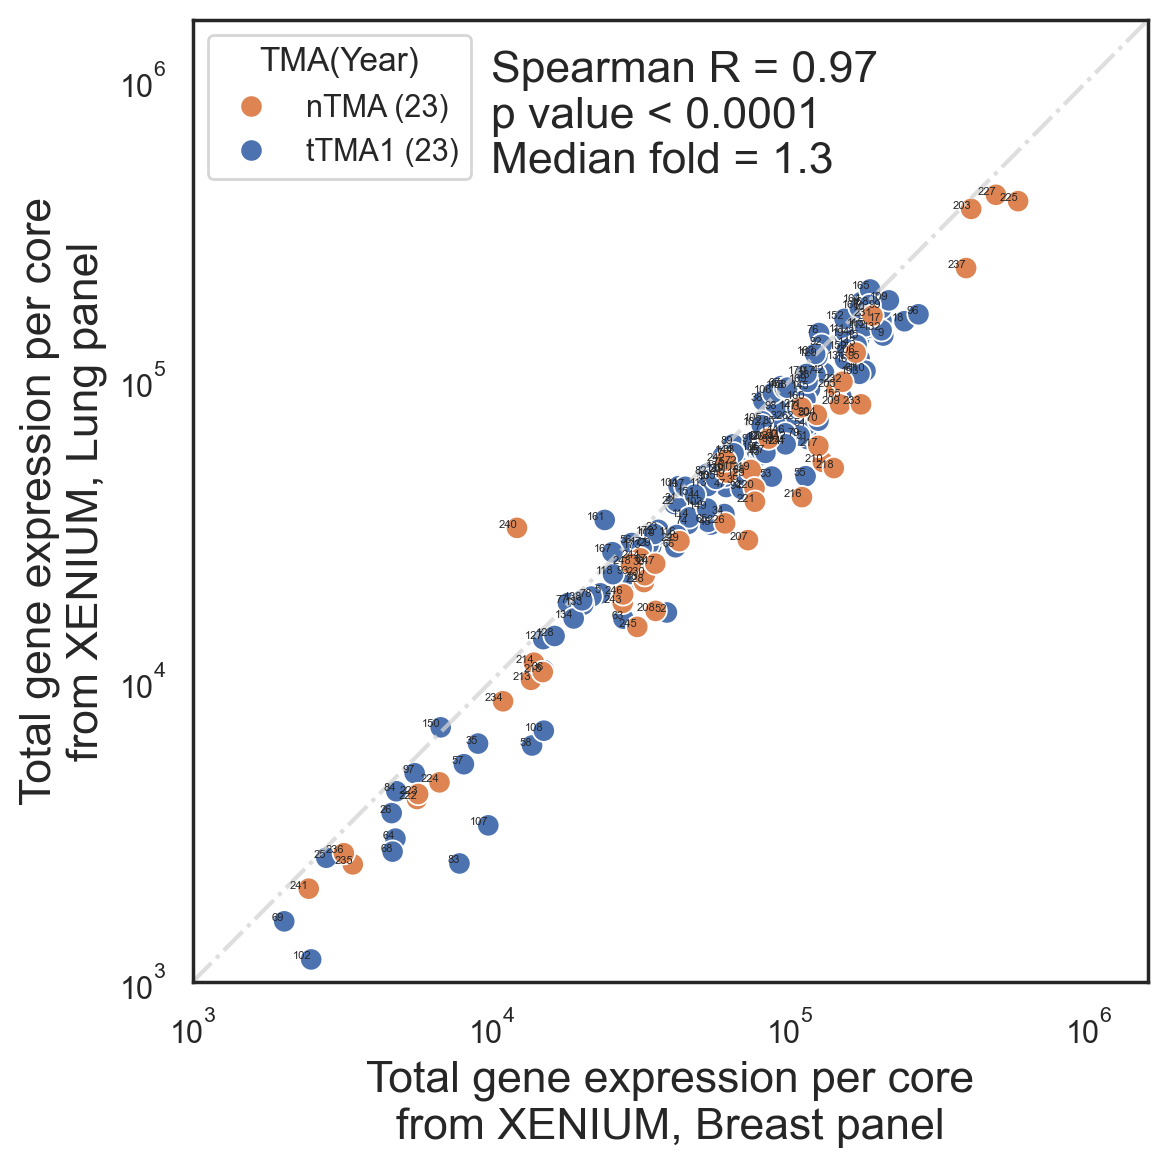

MERSCOPE,breast vs. MERSCOPE,lung


3.32

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


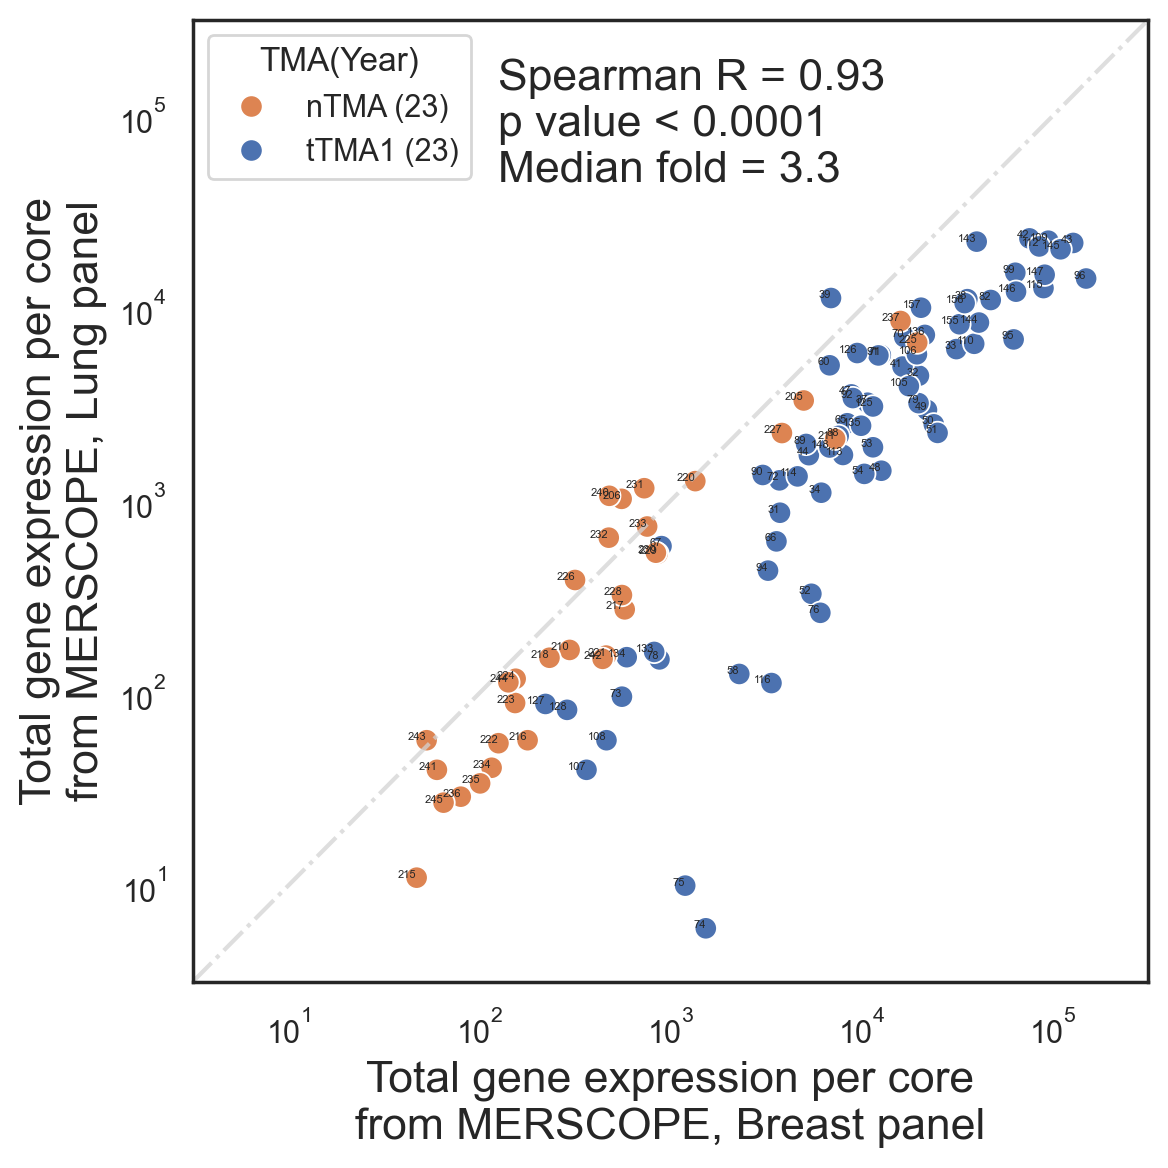

In [51]:


if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

Log_transform_method = 'log10'
fontsize = 16

for Platform_Panel_pair in [
    (Platform_Panels[0], Platform_Panels[1]),  # panel to panel, xenium
    (Platform_Panels[0], Platform_Panels[2]),  # panel to panel, xenium
    (Platform_Panels[3], Platform_Panels[4])   # panel to panel, merscope
]:
    sample1 = Platform_Panel_pair[0]    
    df_1 = df_all[sample1].rename(columns={'count': sample1})
    df_1 = df_1.loc[df_1['code_type'] == 'gene'].drop('code_type', axis=1)

    sample2 = Platform_Panel_pair[1]
    df_2 = df_all[sample2].rename(columns={'count': sample2})
    df_2 = df_2.loc[df_2['code_type'] == 'gene'].drop('code_type', axis=1)

    print(f'{sample1} vs. {sample2}')

    common_genes = np.intersect1d(df_1.gene.unique(), df_2.gene.unique())
    df_1 = df_1.loc[df_1['gene'].isin(common_genes)]
    df_1 = df_1.groupby(['core', 'tissue_type']).agg({sample1: 'sum'}).reset_index()
    df_2 = df_2.loc[df_2['gene'].isin(common_genes)]
    df_2 = df_2.groupby(['core', 'tissue_type']).agg({sample2: 'sum'}).reset_index()

    df_both = pd.merge(df_1, df_2, on=['core', 'tissue_type'], how='inner')
    df_both = df_both.loc[~df_both['core'].isin([6, 24, 212, 238, 239])]
    df_both['fold'] = df_both.apply(lambda row: round(row[sample1] / row[sample2], 3), axis=1)
    m_fold = df_both['fold'].median()
    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)
    # df_both = log_transform(df_both, method=Log_transform_method, exclude_cols=['fold', 'core'])

    df_both.reset_index(inplace=True)
    df_both['Core source'] = df_both['core'].apply(lambda x: 'tTMA1 (23)' if int(x) < 200 else 'nTMA (23)')
    # df_both = df_both.loc[df_both['fold'] < 0.5]
    display(round(df_both['fold'].median(), 2))

    lims = [10**0.5, 10**5.5]
    if 'Xenium' in sample1 and 'Xenium' in sample2:
        lims = [10**3, 10**6.2]

    sns.set(style='white', rc={'figure.figsize': (6, 6), 'figure.dpi': 200})
    
    ax = sns.scatterplot(data=df_both, x=f"{sample1}", y=f"{sample2}", hue='Core source', alpha=1, s=65)
    plt.xlabel(f"Total gene expression per core\nfrom {sample1.split(',')[0].upper()}, {sample1.split(',')[1].capitalize()} panel", fontsize=fontsize)
    plt.ylabel(f"Total gene expression per core\nfrom {sample2.split(',')[0].upper()}, {sample2.split(',')[1].capitalize()} panel", fontsize=fontsize)

    plt.plot(lims, lims, color='#D3D3D3', linestyle='-.', alpha=0.75)
    r, p = sp.stats.spearmanr(df_both[f"{sample1}"], df_both[f"{sample2}"])
    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"


    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(lims[0], lims[1])
    plt.ylim(lims[0], lims[1])

    # Sorting the legend
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = handles[1:-3] + handles[-2:], labels[1:-3] + labels[-2:]
    sorted_labels, sorted_handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(sorted_handles, sorted_labels, title='TMA(Year)', loc='upper left')

    annotation_text = f"Spearman R = {round(r, 2)}\np value {p_text}\nMedian fold = {m_fold}"
    if 'Xenium' in sample1 and 'Xenium' in sample2:
        plt.text(10**4, 10**6.1, annotation_text, fontsize=fontsize, verticalalignment='top')
    else:
        plt.text(10**2.1, 10**5.3, annotation_text, fontsize=fontsize, verticalalignment='top')

    # Add labels for each point using the 'core' column
    for idx, row in df_both.iterrows():
        plt.text(row[sample1], row[sample2], str(row['core']), fontsize=4, ha='right')

    plt.tight_layout()
    plt.savefig(f'{wd}/figures/Fig_1/supp_1_reproducibity_{sample1}_vs_{sample2}.png', bbox_inches='tight',transparent=True)
    plt.savefig(f'{wd}/figures/Fig_1/supp_1_reproducibity_{sample1}_vs_{sample2}.eps', bbox_inches='tight',transparent=True)
    plt.show()


# MERSCOPE: Round 1 breast vs. round 2 breast 

sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_breast_htma_round1
sample: merscope_breast_normal_round1
sample: merscope_lung_htma
sample: merscope_lung_normal
MERSCOPE,breast(10µm) vs. MERSCOPE,breast(5µm)


3.43

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


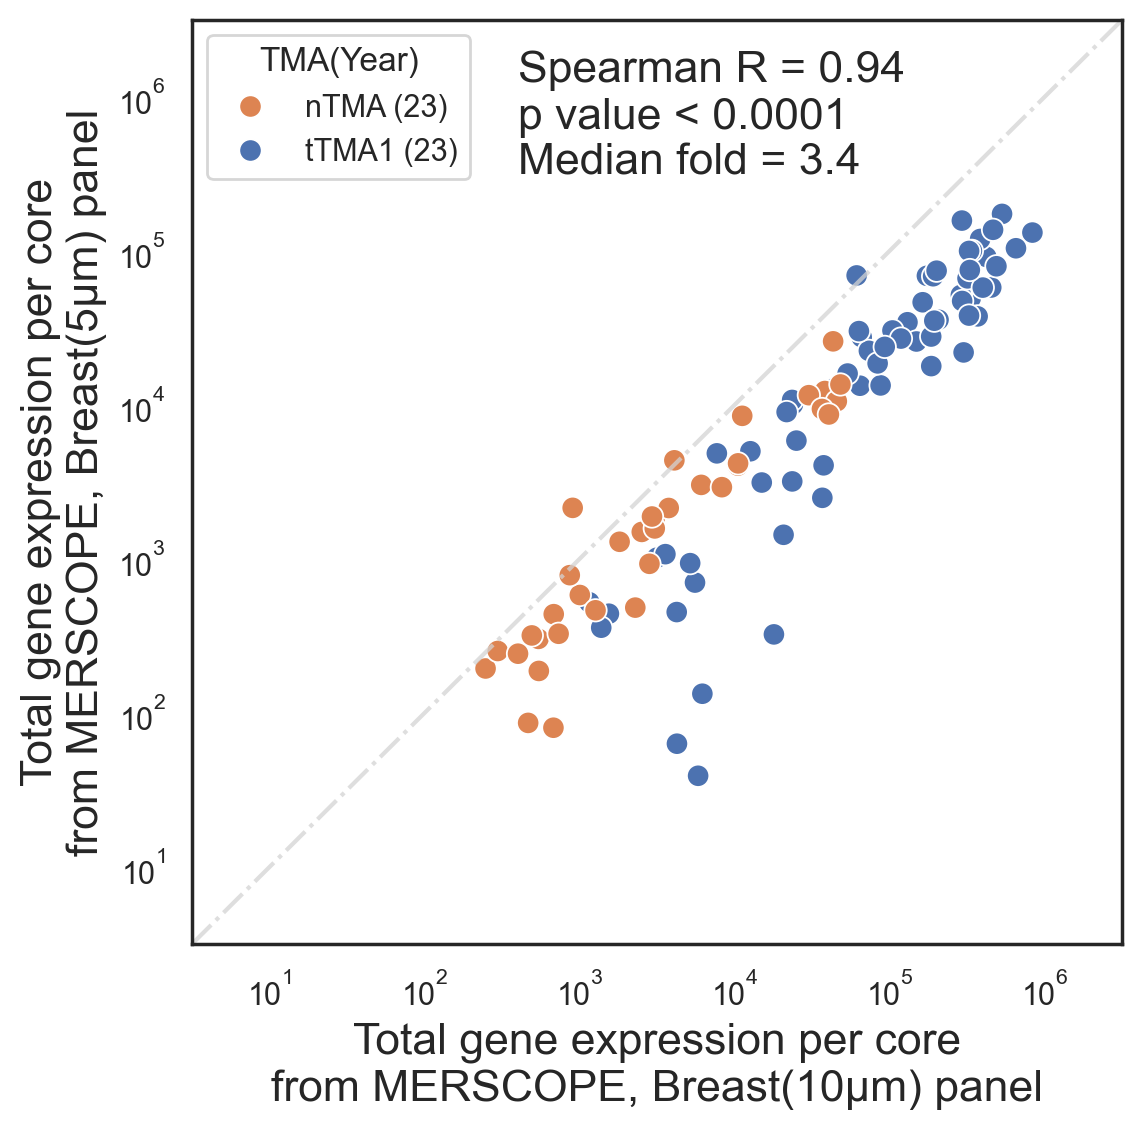

MERSCOPE,breast(5µm) vs. MERSCOPE,lung(5µm)


1.11

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


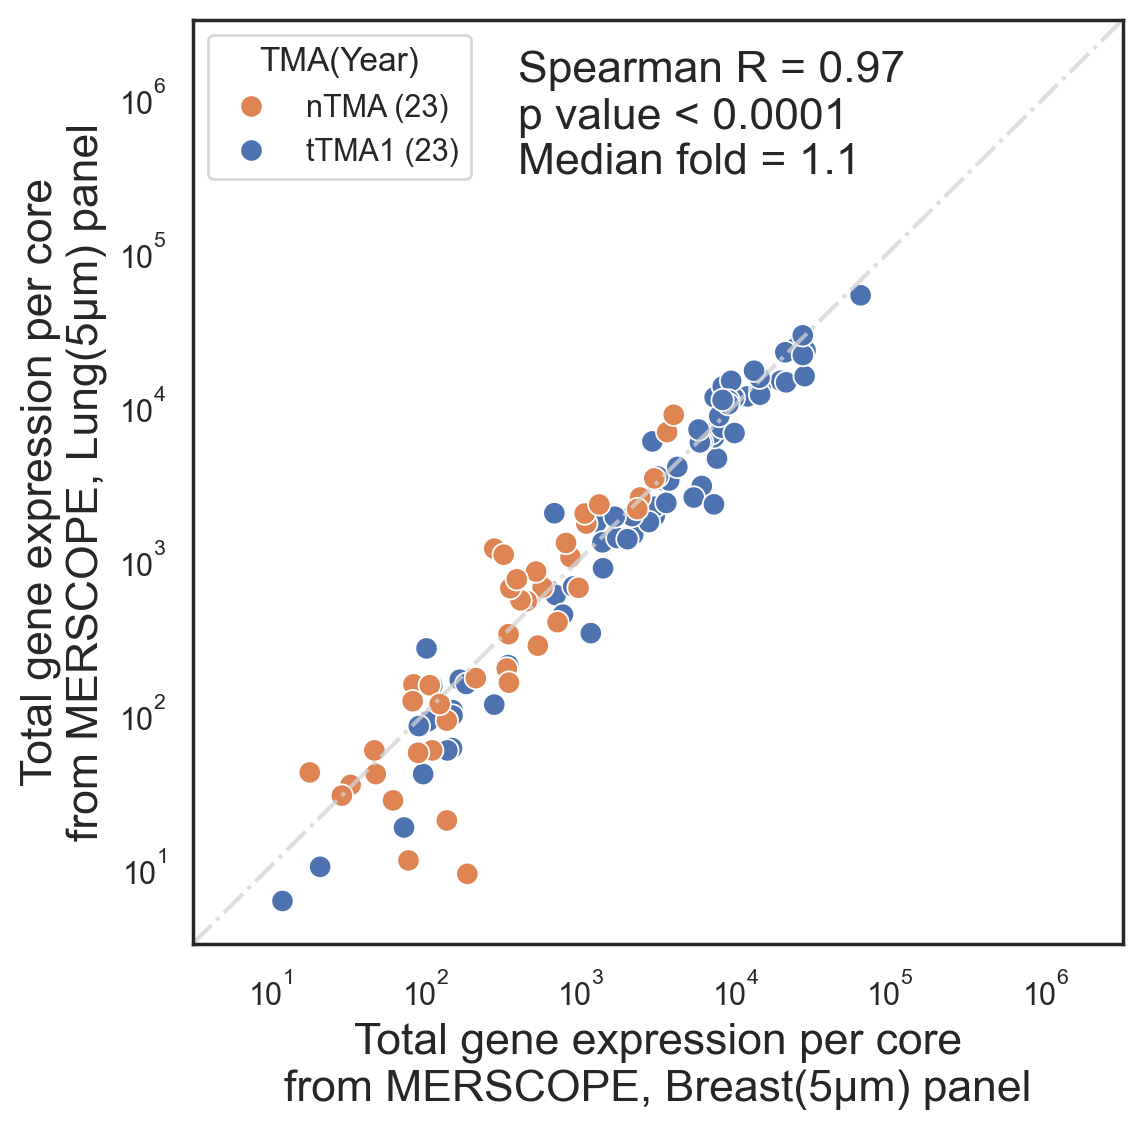

MERSCOPE,breast(10µm) vs. MERSCOPE,lung(5µm)


3.32

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


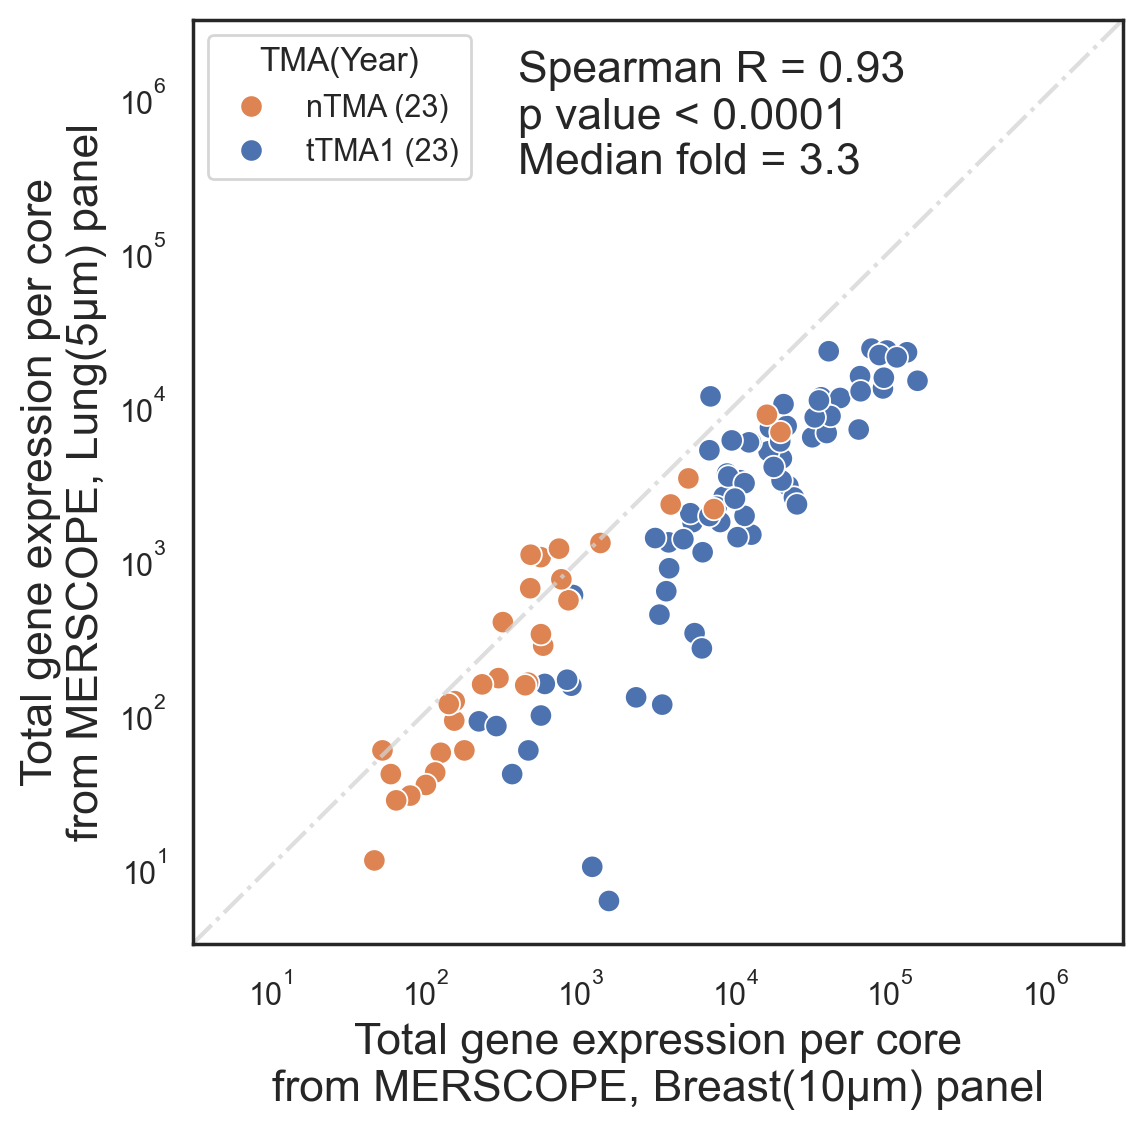

In [16]:
df_t_all = {}

samples = ['merscope_breast_htma',
            'merscope_breast_normal',
            'merscope_breast_htma_round1',
            'merscope_breast_normal_round1',
            'merscope_lung_htma',
            'merscope_lung_normal']

for sample in samples:
    print (f'sample: {sample}')
    df_t, df_core, gene_list = load(sample)
    df_t_all[sample] = df_t

df_all = {}

Platform_Panels =  ['MERSCOPE,breast(10µm)',
                    'MERSCOPE,breast(5µm)',
                    'MERSCOPE,lung(5µm)',
                    ]

for i in range(0,3):
    df_all[Platform_Panels[i]] = pd.DataFrame()
    df_htma = df_t_all[samples[2*i]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_htma])
    df_normal = df_t_all[samples[2*i+1]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_normal])


for Platform_Panel_pair in [(Platform_Panels[0],Platform_Panels[1]),
                            (Platform_Panels[1],Platform_Panels[2]),
                            (Platform_Panels[0],Platform_Panels[2])]:

    sample1 = Platform_Panel_pair[0]    
    df_1 = df_all[sample1].rename(columns={'count':sample1})
    df_1 = df_1.loc[df_1['code_type']=='gene'].drop('code_type', axis=1)

    sample2 = Platform_Panel_pair[1]
    df_2 = df_all[sample2].rename(columns={'count':sample2})
    df_2 = df_2.loc[df_2['code_type']=='gene'].drop('code_type', axis=1)

    print (f'{sample1} vs. {sample2}')

    common_genes = np.intersect1d(df_1.gene.unique(),df_2.gene.unique())
    df_1 = df_1.loc[df_1['gene'].isin(common_genes)]
    df_1 = df_1.groupby(['core', 'tissue_type']).agg({sample1:'sum'}).reset_index()
    df_2 = df_2.loc[df_2['gene'].isin(common_genes)]
    df_2 = df_2.groupby(['core', 'tissue_type']).agg({sample2:'sum'}).reset_index()

    df_both = pd.merge(df_1, df_2, on=['core', 'tissue_type'], how='inner')
    df_both = df_both.loc[~df_both['core'].isin([6, 24, 212, 238, 239])]
    df_both['fold'] = df_both.apply(lambda row: round(row[sample1] / row[sample2], 3), axis=1)
    m_fold = df_both['fold'].median()
    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)

    # df_both = log_transform(df_both, method=Log_transform_method, exclude_cols=['fold', 'core'])

    df_both.reset_index(inplace=True)
    df_both['Core source'] = df_both['core'].apply(lambda x: 'tTMA1 (23)' if int(x) < 200 else 'nTMA (23)')

    display(round(df_both['fold'].median(), 2))

    lims = [10**0.5, 10**6.5]

    sns.set(style='white', rc={'figure.figsize': (6, 6), 'figure.dpi': 200})
    
    ax = sns.scatterplot(data=df_both, x=f"{sample1}", y=f"{sample2}", hue='Core source', alpha=1, s=65)
    plt.xlabel(f"Total gene expression per core\nfrom {sample1.split(',')[0].upper()}, {sample1.split(',')[1].capitalize()} panel", fontsize=fontsize)
    plt.ylabel(f"Total gene expression per core\nfrom {sample2.split(',')[0].upper()}, {sample2.split(',')[1].capitalize()} panel", fontsize=fontsize)

    plt.plot(lims, lims, color='#D3D3D3', linestyle='-.', alpha=0.75)
    r, p = sp.stats.spearmanr(df_both[f"{sample1}"], df_both[f"{sample2}"])
    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"

    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(lims[0], lims[1])
    plt.ylim(lims[0], lims[1])

    # Sorting the legend
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = handles[1:-3] + handles[-2:], labels[1:-3] + labels[-2:]
    sorted_labels, sorted_handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(sorted_handles, sorted_labels, title='TMA(Year)', loc='upper left')

    annotation_text = f"Spearman R = {round(r, 2)}\np value {p_text}\nMedian fold = {m_fold}"
    plt.text(10**2.6, 10**6.3, annotation_text, fontsize=fontsize, verticalalignment='top')
    # # Add labels for each point using the 'core' column
    # for idx, row in df_both.iterrows():
    #     plt.text(row[sample1], row[sample2], str(row['core']), fontsize=8, ha='right')


    plt.savefig(f'{wd}/figures/Fig_1/supp_1_reproducibity_{sample1}_vs_{sample2}.png', bbox_inches='tight',transparent=True)
    plt.savefig(f'{wd}/figures/Fig_1/supp_1_reproducibity_{sample1}_vs_{sample2}.eps', bbox_inches='tight',transparent=True)
    plt.show()